<a href="https://colab.research.google.com/github/akshatsingh523/Underwater-Object-Detection/blob/main/Detection_using_Yolov4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone Scaled_YOLOv4
!git clone https://github.com/roboflow-ai/ScaledYOLOv4.git  # clone repo
%cd /content/ScaledYOLOv4/
#checkout the yolov4-large branch
!git checkout yolov4-large

Cloning into 'ScaledYOLOv4'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 133 (delta 0), reused 2 (delta 0), pack-reused 128
Receiving objects: 100% (133/133), 409.42 KiB | 1.82 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/ScaledYOLOv4
Already on 'yolov4-large'
Your branch is up to date with 'origin/yolov4-large'.


In [ ]:
import torch
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [ ]:
#install mish activation funciton for cuda
%cd /content/
!git clone https://github.com/JunnYu/mish-cuda
%cd mish-cuda
!python setup.py build install

/content
fatal: destination path 'mish-cuda' already exists and is not an empty directory.
/content/mish-cuda
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/extension.py:134: UserWarning: Unknown Extension options: 'headers'
  warnings.warn(msg)
running build
running build_py
running egg_info
writing src/mish_cuda.egg-info/PKG-INFO
writing dependency_links to src/mish_cuda.egg-info/dependency_links.txt
writing requirements to src/mish_cuda.egg-info/requires.txt
writing top-level names to src/mish_cuda.egg-info/top_level.txt
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:502: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
reading manifest file 'src/mish_cuda.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'src/mish_cuda.egg-info/SOURCES.txt'
running build_ext
/usr/local/li

In [ ]:
!pip install -U PyYAML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/ScaledYOLOv4/


/content/ScaledYOLOv4


In [ ]:
%cd /content

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WMBOqkEzTUre6KzfvX45")
project = rf.workspace("objectdetection-xpbt7").project("underwater-object-detection-mcjr0")
dataset = project.version(6).download("yolov4scaled")


/content
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Underwater-Object-Detection-6 in yolov4scaled:: 100%|██████████| 322/322 [00:00<00:00, 4962.80it/s]


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

train: /content/Underwater-Object-Detection-6/train/images
val: /content/Underwater-Object-Detection-6/valid/images
test: /content/Underwater-Object-Detection-6/test/images

nc: 2
names: ['Biodegradable', 'NonBiodegradable']

roboflow:
  workspace: objectdetection-xpbt7
  project: underwater-object-detection-mcjr0
  version: 6
  license: CC BY 4.0
  url: https://universe.roboflow.com/objectdetection-xpbt7/underwater-object-detection-mcjr0/dataset/6

In [ ]:
dataset.location

'/content/Underwater-Object-Detection-6'

#Inspect Model Configuration and Architecture

Let's look at the Scaled-YOLOv4 Configuration architecture

In [ ]:
%cat /content/ScaledYOLOv4/models/yolov4-csp.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P3/8
  - [36,75, 76,55, 72,146]  # P4/16
  - [142,110, 192,243, 459,401]  # P5/32

# yolov4-csp backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2
   [-1, 1, Bottleneck, [64]],
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4
   [-1, 2, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 5-P3/8
   [-1, 8, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 7-P4/16
   [-1, 8, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 9-P5/32
   [-1, 4, BottleneckCSP, [1024]],  # 10
  ]

# yolov4-csp head
# na = len(anchors[0])
head:
  [[-1, 1, SPPCSP, [512]], # 11
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [8, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, Bott

# Train Custom Scaled-YOLOv4 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights.
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
orig_dataset_directory = dataset.location
orig_dataset_directory

'/content/Underwater-Object-Detection-6'

In [ ]:
%cd {orig_dataset_directory}
%cp -r {orig_dataset_directory} /content/ScaledYOLOv4

/content/Underwater-Object-Detection-6


In [ ]:
# train scaled-YOLOv4 on custom data for 100 epochs
# time its performance
%%time
%cd /content/ScaledYOLOv4/
!python /content/ScaledYOLOv4/train.py --img 96 --batch 16 --epochs 25 --data {dataset.location}/data.yaml --cfg ./models/yolov4-csp.yaml --weights '' --name yolov4-csp-results  --cache

/content/ScaledYOLOv4
2023-12-21 16:04:52.420311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 16:04:52.420371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 16:04:52.421808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 16:04:52.431828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 16:04:53.595

# Evaluate Custom Scaled-YOLOv4 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

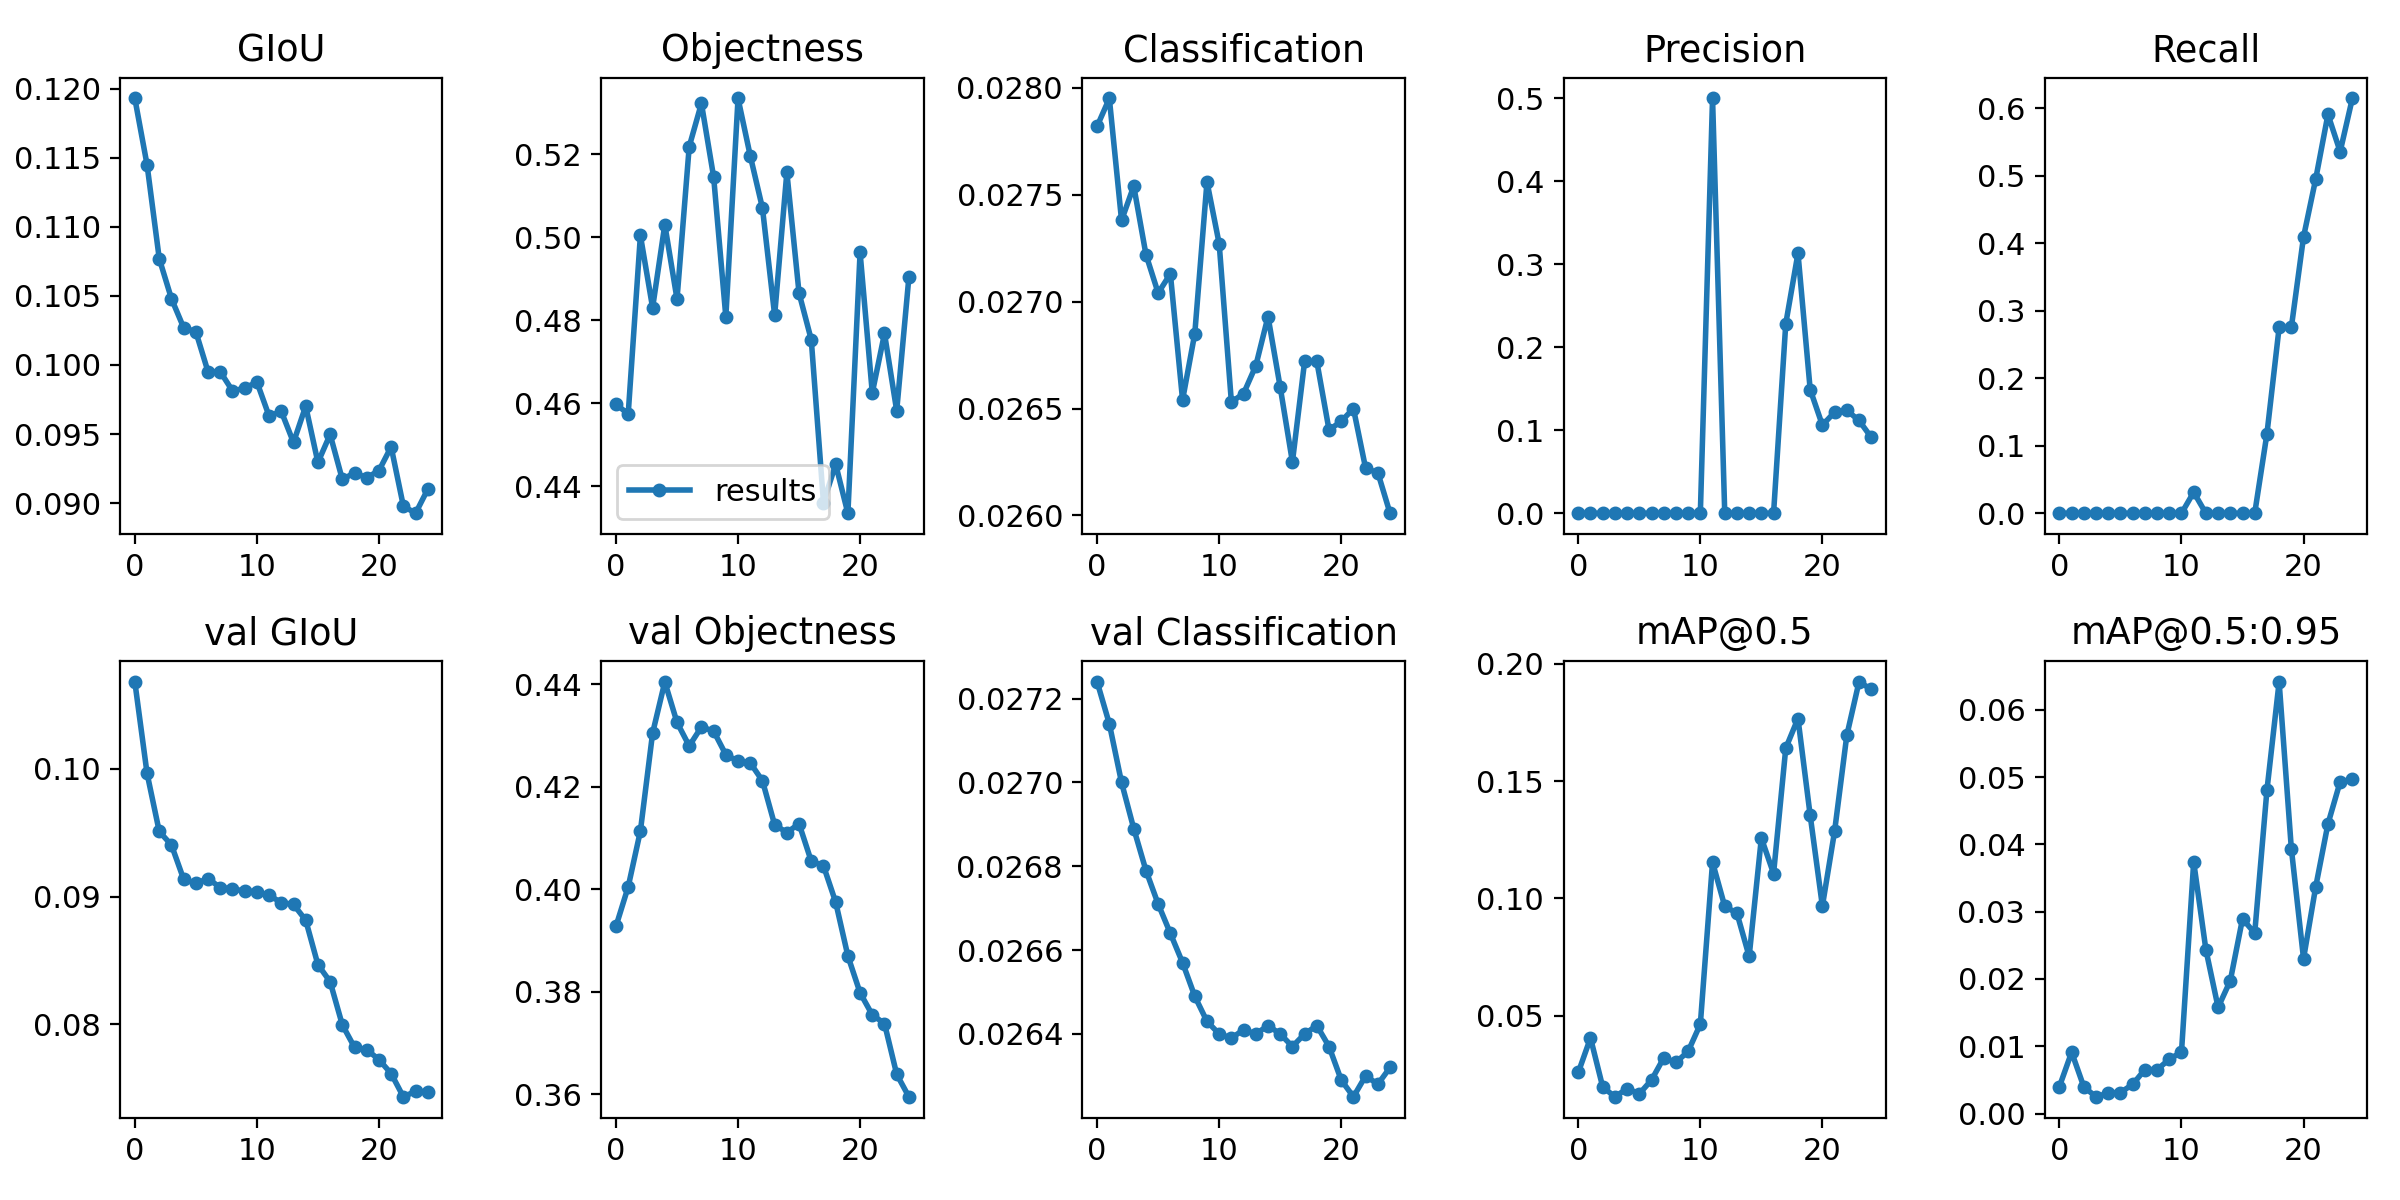

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
#from utils.general import plot_results  # plot results.txt as results.png
from IPython.display import Image, display
display(Image('/content/ScaledYOLOv4/runs/exp7_yolov4-csp-results/results.png'))  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


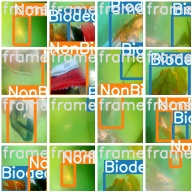

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/ScaledYOLOv4/runs/exp7_yolov4-csp-results/test_batch0_gt.jpg', width=1000)

GROUND TRUTH AUGMENTED TRAINING DATA:


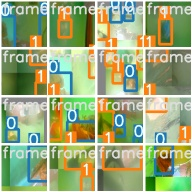

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/ScaledYOLOv4/runs/exp7_yolov4-csp-results/train_batch0.jpg', width=900)